In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Las líneas de abajo son opcionales

import mplhep as hep
# plt.style.use('default')
hep.style.use('ROOT')

$$ \LARGE p_i = \frac{1}{\mathcal{Z}} e^{-\varepsilon_i /k_B T} = \frac{e^{-\varepsilon_i /k_B T}}{\sum^M_{j=1} e^{-\varepsilon_j /k_B T} }$$

According to Scipy this is the same as 
$$ \LARGE f(\kappa) = \frac{ 1-e^{-\lambda}}{ 1-e^{-\lambda N}}e^{-\lambda \kappa} $$
With $\Large \lambda =\beta = 1/k_B T$ and $\Large \kappa = \varepsilon_i$


## Write a routine that generates N initial conditions ($x_0 , p_0$) with a Boltzmann probability distribution for our ideal gas particle in the piston and calculates $W_c(x_0, p_0) + W_e(x_0, p_0)$ for each.

The conditions are as follows:
- We will limit our starting $x_0$ to be contained in a cylinder between $0$ and $L=20$. I will give it a uniform distribution.
- $p_0$ will have a normal distribution with a $\sigma = mV$ 
- We will take the following values for paramenters :
    - $m=2,k_BT =8,V =2, L=20, L' =19$

<!-- 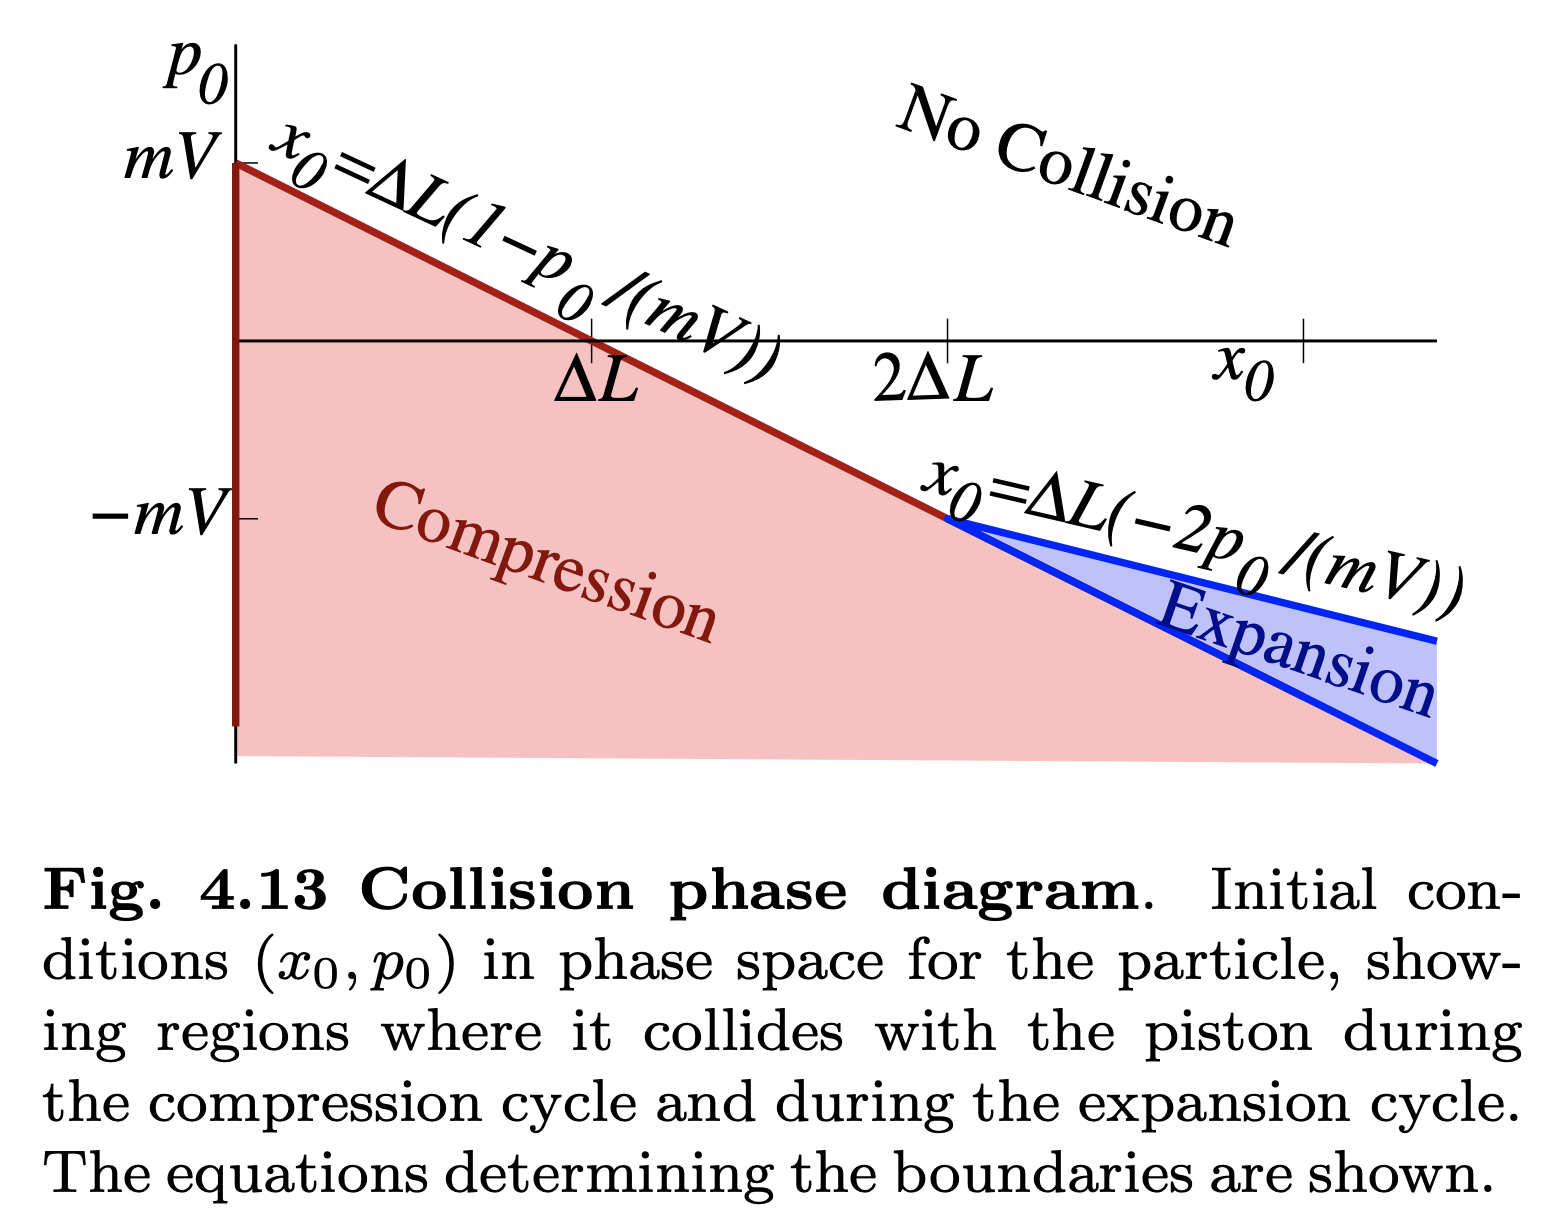 -->
<center>
<img src="Phase_space.png" width="50%">
</center>

In [ ]:
def generate_space(Npoints: int , m: int=2, V: int = 2, L: int=20, kT: int=8,**kwargs) -> tuple: 
    '''
      Generates Npoints of initial conditions with a boltzmann distribution for x0 and p0
    '''
    x0=stats.uniform.rvs(size=Npoints,loc=0,scale=L,**kwargs)
    p0=stats.norm.rvs(scale=(m*V)**1,loc=0,size=Npoints,**kwargs)
    return x0,p0


def work(x0 ,p0 ,m: int = 2 ,V: int = 2 ) -> tuple:  
    '''
    Calculates the compression work and expansion work done on the particle (We,Wc) respectively
    '''

    Wc = .5*m*V**2 + p0*V # Trabajo en expansión
    We = .5*m*V**2 - p0*V # Trabajo en compresión 
    return Wc,We


def calculate_work(Npoints,L=20,Lprime=19,V=2,m=2,kT=8,**kwargs):
    """
    Make a simulation instance. Generate a phase space for `x0` and `p0` given `L, Lprime, V, m` and make the 
    Work in during compression and expansion 0 due to the kinematics of the simulation.

    ## Returns
    Wc,We : arrays
    """
    x0,p0 = generate_space(Npoints,m,V,L,kT=8,**kwargs)
    Wctemp,Wetemp = work(x0,p0,m,V)
    deltaL = L-Lprime
    x1 = (deltaL)*(1-p0/(m*V)) 
    x2 = (deltaL)*(-2*p0/(m*V))
    # Make regions where work should be 0 based on phase space diagram above
    xcomp_cut = (x0>x1) 
    xexp_cut = (x0>x2)

    # pexp_cut =  (p0**2/(2*m)) <= kT | ( abs(p0/m) < V)
    Wctemp[ xcomp_cut  | ((p0/m) >= V) ] = 0
    Wetemp[ xexp_cut | ((p0/m) <= -V) ] = 0 
    Wc= Wctemp[:]
    We= Wetemp[:]
    return Wc,We

Here we take a look at the distributions of $W_e$ and $W_c$ before making any selections regading our kinematics or our phase space conditions

In [ ]:
x = np.linspace(-35,35,1000)
x0,p0= generate_space(1000)
Wc,We = work(x0,p0)
bins=range(-35,35)

plt.hist(We,bins=bins,density=True,histtype='step',label='$W_e$')
plt.hist(Wc,bins=bins,density=True,histtype='step',label='$W_c$')

plt.plot(x,stats.norm.pdf(x,scale=We.std(),loc=We.mean()),
         color='r',label='$W_e$ fit')
plt.plot(x,stats.norm.pdf(x,scale=Wc.std(),loc=Wc.mean()),
         color='blue',label='$W_c$ fit')
plt.legend()
plt.title('Initial distribution of Work in each cycle')
plt.show()

In [ ]:
m=V=2

# plt.figure(dpi=120,figsize=(8,5))
plt.hist(p0,bins=range(-14,15),histtype='step')
plt.hist(p0[p0 >= m*V],bins=range(-14,15),label='$p_0 \geq mV$ (in compression)')
plt.hist(p0[p0 <= -m*V],bins=range(-14,15),label='$p_0 \leq -mV$ (in expansion)')
plt.title('Momentum phase space excluded')
plt.legend()
plt.ylim(0,130)
plt.show()

Here we take a look at the distributions of $W_e + W_c$ **with** our kinematics or our phase space conditions

In [ ]:
Wc,We = calculate_work(1_000) # N = 1000
Wnet = Wc + We
mean = Wnet.mean() # Eq 4.18
bins= np.arange(-20,20)

plt.hist([We,Wc], bins=bins,log=True,
         label=['$W_e$','$W_c$'],
         histtype='step')
plt.legend(title =f'Mean is {mean:.3f}',loc=2)
plt.title('Distribution of Work in each cycle \n(after applying our kinematic req.)')
plt.xlabel('Work [J]')
plt.ylabel('Counts')
plt.show()

# Calculate the average work done by the piston $W_c +W_e$. How big must N be before you get a reliable average? 

In [ ]:
mlist=[]
start,stop,step=10,1_100,1
for i in range(start,stop,step):
    Wc,We = calculate_work(i)
    Wnet = Wc + We
    mean = Wnet.mean()
    mlist.append(mean)

plt.plot(range(start,stop,step),mlist,'.',label='$(\overline{W_c + W_e})_i$');

plt.title('$\overline{W_c + W_e}$ Convergence')
plt.ylabel('$\overline{W_c + W_e}$ \t \t[J]')
plt.xlabel('Number of initial conditions')
plt.axhline(y=np.mean(mlist),color='r',label=f'Mean at {np.mean(mlist):.3}')
plt.axhline(y=0,color='k',label='y=0')
plt.legend()
plt.show()



N must be at least around 500 to be reliable based on this plot to show how the average W converges to a value.


## Does your average obey eqn 4.18?
Eqn. 4.18 is $ \overline{W_c + W_e} \geq 0$


Yes it does.
The mean value for the plot above is

In [ ]:
np.mean(mlist)

## Use your routine with $N = 1,000$ to calculate Jarzynski’s exponentially weighted average $\overline{{\exp (−W/k_B T)}}$ in eqn 4.19, and compare to $\exp (-\overline{W}/ k_B T )$. Do this 200 times, and plot a histogram of each. Does the Jarzynski equality appear to hold?

One iteration

In [ ]:
Wc,We = calculate_work(1_000) # N = 1000
Wnet = Wc + We
mean = Wnet.mean() # Eq 4.18
kT=8

print(f"Jarzynki's weighted average {np.mean(np.exp(-Wnet/kT)):.4f}")
print(f"exp(bar(-W)/kT) = {np.exp(-mean/kT):.4f}")


200 iterations and now plotting the histograms

In [ ]:
Jar_avg=[]
expW_kT = []
for i in range(200):
    Wc,We = calculate_work(1_000) # N = 1000
    Wnet = Wc + We
    mean = Wnet.mean()
    Jar_avg.append(np.mean( np.exp(-Wnet/kT) ))
    expW_kT.append(np.exp(-mean/kT))

bins=np.arange(0.95,1.15,.005)
# plt.figure(figsize=(12,8))
plt.hist(Jar_avg,histtype='step',label="Jarzynski $\overline{\exp{(-W/k_BT)}}$"+f'= {np.mean(Jar_avg):.3f}',
         bins=bins,lw=3)
plt.hist(expW_kT,histtype='stepfilled',label="$\exp{(-\overline{W}/k_B T)}$"+f'= {np.mean(expW_kT):.3f}',
         bins=bins)
plt.legend()
plt.ylabel('Counts (A.U.)')
plt.xlabel('Exponential Averages')
plt.title(r"Comparison between Jarzynski's weighted avg and $e^{(-\overline{W}/k_BT)}$",size=25)
plt.show()

The theorem seems to hold that 
$$ \huge \overline{e^{(-W/k_BT)}} \geq e^{(-\overline{W}/k_BT)}$$